<font size="8">Build an ANUGA Model (BAM) </font>

<font size="3">In this notebook, we will:

- 



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True.</font> <br>
<font size=5 color='blue'> If you are running on your own computer, set the variable yes_colab = False </font>


In [1]:
yes_colab = False


<font size=6> Step #1a: Set working directory <br> </font>



<font size=5 color='green'> If you are running in Google Colab, when you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>



In [2]:
import os
import sys
from pathlib import Path

your_path = Path(os.getcwd() + '/')
if yes_colab:
    where_to_mount = '/content/drive/'
    from google.colab import drive
    drive.mount(where_to_mount, force_remount=True)
    mounted_drive = Path(where_to_mount) / 'MyDrive' 
    sys.path.append(str(mounted_drive / 'installations'))
    path_ancillary = mounted_drive / 'ancillary'
    Path(mounted_drive / 'installations').mkdir(parents=True, exist_ok=True)

else:
    mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))

print('Your working directory is %s' %(mounted_drive))



Your working directory is /Users/alchrist/Documents/GitHub/BAM


<font size=6> Step #1b: Install and import packages. <font> <br>

<font size=5 color='green'> If you are running in Google Colab, this cell should install all Python packages you need for each tutorial. </font> <br>
<font size=5 color='blue'> If you are running on your own computer, the packages were already installed when you installed the conda environment </font>


In [3]:
import os
os.chdir(mounted_drive)
if yes_colab:
  if os.path.isdir(mounted_drive / 'BAM'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive / 'BAM')
    #!git fsck --full
    # !git add -A 
    !git stash   
    !git pull
    # !rm -rf {mounted_drive/'BAM'}

  else:
    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/BAM.git


In [4]:
if yes_colab:
  print('\n## Installing the Python packages needed for these tutorials\n')
  try:
    import geopandas as gpd
  except:
    !/bin/bash $mounted_drive/BAM/notebooks/install_packages_colab_debug.sh


In [5]:
path_ancillary = mounted_drive / 'ancillary'
path_code = mounted_drive / 'scripts/'
path_templates = mounted_drive /  'templates/'
path_configs = mounted_drive / 'configs/'
sys.path.insert(1,str(path_code))
print(path_code)
print(path_ancillary)

path_examples = mounted_drive / 'examples'
path_examples.mkdir(parents=True, exist_ok=True)

/Users/alchrist/Documents/GitHub/BAM/scripts
/Users/alchrist/Documents/GitHub/BAM/ancillary


In [6]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
from scipy import *

## ANUGA packages
import anuga
from anuga.utilities.plot_utils import Make_Geotif
from anuga.coordinate_transforms.geo_reference import Geo_reference
from anuga.utilities import animate
from anuga import myid, numprocs, finalize, barrier
from anuga.parallel.parallel_inlet_operator import Parallel_Inlet_operator


In [7]:
try:
  import pyTMD
except:
  !pip install pytmd

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)
from BYOM_extra import make_mesh_polygons, determine_riverscale
from polygon_tools import getpolygonpoints, removenearbypoints, delete_holes


# Standard packages

import fnmatch
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point, LineString
## Plotting modules
import matplotlib.pyplot as plt

## Google Earth Packages
import ee
from ee import batch
# import geemap

import zipfile



/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:42: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:43: UserWarning: UserWarning
  warnings.warn('UserWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/BYOM_extra.py:15: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/BYOM_extra.py:16: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size=6> Step #1c: Choose to run the Demo or set up your own AOI. If running demo, unzip example files in Komo.zip <font> 




In [8]:
demo = False
if demo:
    with zipfile.ZipFile("komo_starter.zip", 'r') as zip_ref:
        zip_ref.extractall(path_examples)
    AOI = 'komo'
else:
    AOI = 'magdalena'

<font size=6, color ='black' > Step #2: Set the AOI and working directory  </font>


AOI should match the name of the folder where files will be saved

In [9]:


Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 10 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is magdalena
Resolution of this setup is 10m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/magdalena
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 

In [10]:
path_working,folders = build_directory(path_examples, AOI)

parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
EPSG            = int(parameters['EPSG'][0])                         # Coordinate system






##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/magdalena
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 8 Setup_Files/Setup_RST --> Rasters

In [11]:
try:
    ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))
except:
    os.system('gdalwarp -overwrite -tr %s %s %s%s_GEBCO_%s.tif %s%s_GEBCO_%s.tif '\
              ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
              %(xres,yres,folders[8],AOI,ref_res,folders[8],AOI,xres,ulx,lry,lrx,uly))
    ref = rasterio.open('%s%s_GEBCO_%s.tif' %(folders[8],AOI,res))
    
ref_profile = ref.profile


In [12]:
model_domain = gpd.read_file('%s/%s_input.shp' %(folders[0],AOI))
model_domain.crs = 4326
domain_name = ''
Path(domain_name).mkdir(parents=True, exist_ok=True)

try:
    tide_bnd = gpd.read_file('%s/%s_tidebnd.shp' %(folders[0],AOI))
    tide_bnd.crs = 4326
    tide_bnd.to_file('%s/%s_tidebnd.shp' %(folders[3],AOI))
except:
    print('Tidal boundary is not defined yet, choosen random side as tides! NW')
    left,top,right,bottom = model_domain.total_bounds
    tide_bnd = gpd.GeoDataFrame(crs=model_domain.crs,geometry =  [LineString([Point(left,top), Point(left,bottom)])])
    tide_bnd.to_file('%s/%s_tidebnd.shp' %(folders[3],AOI))

#     tide_bnd_EPSG = []
#     tideLAT_EPSG = -9999
#     tideLON_EPSG = -9999


print('Tidal boundary is defined by User File (%s_tidebnd.shp)' %(AOI))
if tide_bnd.crs != 'EPSG:4326':
    tide_bnd = tide_bnd.to_crs('EPSG:4326')    
tide_centroid = tide_bnd.centroid

tide_bnd_EPSG = tide_bnd.to_crs('EPSG:%s' %(EPSG))
tide_EPSG_centroid = tide_bnd_EPSG.centroid

tideLAT_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[1][0],2)
tideLON_EPSG = round(tide_EPSG_centroid.geometry[0].coords.xy[0][0],2)



Tidal boundary is defined by User File (magdalena_tidebnd.shp)


/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_39327/95133849.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tide_centroid = tide_bnd.centroid


In [13]:
segment_width = 20
pixel_step = int(round(segment_width/res))

med_width, riverscale, cellsperwidth = determine_riverscale(folders,
                                          AOI,
                                          ref,
                                          parameters,
                                          pixel_step,
                                          False)       




##############################################################################################
######################################## [River Scale] #######################################
##############################################################################################



/Users/alchrist/anaconda3/envs/BAM_dev/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0...10...20...30...40...50...60...70...80...90...100 - done.

[Get Riverscale][Get Median Width of Rivers] .......

##################### Median river width is 650.0m

[Get Riverscale][How many cells per width] .......

##################### Cells per river width is 5

[Get Riverscale][Estimate maximum triangle size to maintain 5 per median 650.0m river width] .......

##################### Therefore, max triangle scale is 8450m2


In [72]:
uniform = True # False if you want to refine certain meshes
base_triangle = 400000
base_length  = int((base_triangle*2)**0.5)
print('\nBase maximum triangle size is \n%sm2 ' %(base_triangle))



Base maximum triangle size is 
400000m2 


In [73]:

if uniform==False:
    meshes = make_mesh_polygons(folders,
                            AOI,
                            res,
                            parameters,
                            med_width,
                            cellsperwidth,
                            domain_name,False)
#                              os.path.isfile( "%s%s_land_mesh_%s.shp" %(folders[3],delta,res)))



In [74]:

if uniform==False:
    mesh_names = ['river','fullocean','land','lake'] # these names should match polygon names in the setup_shp folder
    mesh_triangles = [riverscale,10000,10000,10000]# Set these as you please
    
    print('\nChosen mesh polygons for refinement are:\n %s\n' %(mesh_names))

    print('Mesh maximum triangle sizes are: \n%s' %(mesh_triangles))
    mesh_shapefiles =[]
    for mesh in range(len(mesh_names)):
        mesh_shapefiles = np.concatenate((mesh_shapefiles,[os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(domain_name)
                for f in fnmatch.filter(files,'%s*%s_mesh_%s.shp' %(AOI,mesh_names[mesh],res))]),axis=0)
    print('\nFound mesh shapefiles for mesh refinement are:')
    print(*mesh_shapefiles,sep='\n')

else:
    mesh_names = ['base']
    mesh_triangles = [base_triangle]
    


In [75]:
mesh_file = 'Meshes'
for mesh in range(len(mesh_names)):
    mesh_file = mesh_file +'_' + mesh_names[mesh] + '_' + str(mesh_triangles[mesh]) + 'm2'
print(mesh_file)

Meshes_base_400000m2


In [76]:
#meshname = '%s%s_%s.tsh' %(folders[3],AOI,mesh_string)
mesh_path = folders[3] / mesh_file  #folders[4] + elevationpath.split('/')[-1] + '/' + mesh_string + '/'

Path('%s' %(mesh_path)).mkdir(parents=True, exist_ok=True)
Path('%s' %(folders[1])).mkdir(parents=True, exist_ok=True)

print('Folder for mesh files is %s' %(mesh_path))

Folder for mesh files is /Users/alchrist/Documents/GitHub/BAM/examples/magdalena/Meshes/Meshes_base_400000m2


In [77]:
# fix,ax = plt.subplots(figsize=(10,10))

# colors = ['r','k','b','c','o','g']
# i=0
# for mesh_shapefile in mesh_shapefiles:
#     tmp = gpd.read_file(mesh_shapefile)
#     tmp.plot(ax=ax,color=colors[i])
#     i=i+1

In [78]:
north

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [79]:
rectangular = True
      
if rectangular:
    print('Model domain is rectangular, clear North, South, West, and East Boundaries')
    extentpoly     = gpd.read_file("%s/%s_extent_%s.shp" %(folders[7],AOI,EPSG))
    ulx,lry,lrx,uly = extentpoly.total_bounds   # Coordiates converted to UTM coordinate system
    temp, domain   = getpolygonpoints(extentpoly,ulx,uly,lrx,lry,base_length)
    perimeter = temp.length
    extent = tuple((point.coords[0][0],point.coords[0][1]) for point in (domain.geometry[:]))
    extent2 = []
    for feat in domain.geometry:
        extent2.append([round(feat.x,5), round(feat.y,5)])
    extent2 = np.array(extent2)
    north = np.where((extent2[:,1]==round(uly,5)))
    south = np.where((extent2[:,1]==round(lry,5)))
    west  = np.where((extent2[:,0]==round(ulx,5)))
    east  = np.where((extent2[:,0]==round(lrx,5)))
    other_tag = np.where((extent2[:,1]!=round(uly,5))&(extent2[:,1]!=round(lry,5))&(extent2[:,0]!=round(ulx,5))&(extent2[:,0]!=round(lrx,5)))
    print('There are a total of %s boundary nodes' %(len(domain)))
    print('There are %s boundary nodes tagged as North boundaries' %(len(north[0])))
    print('There are %s boundary nodes tagged as South boundaries' %(len(south[0])))
    print('There are %s boundary nodes tagged as West boundaries' %(len(west[0])))
    print('There are %s boundary nodes tagged as East boundaries' %(len(east[0])))
    print('There are %s boundary nodes tagged as Other boundaries' %(len(other_tag[0])))
  
else:
    tide_bnd = gpd.read_file("%s/%s_tidebnd.shp" %(folders[0],AOI))
    print('Model domain is irregular, boundary tags are not North, South, East, and West')
    print('Tidal boundary is defined by user: \n%s/%s_tidebnd.shp' %(folders[0],AOI))
    extentpoly     = gpd.read_file("%s/%s_modeldomain.shp" %(folders[7],AOI))
    tide_bnd = tide_bnd.to_crs(extentpoly.crs)
    ulx,lry,lrx,uly = extentpoly.total_bounds   # Coordiates converted to UTM coordinate system
    temp, domain   = getpolygonpoints(extentpoly,ulx,uly,lrx,lry,base_length)
    perimeter = temp.length
    extent = tuple((round(point.coords[0][0],9),round(point.coords[0][1],9)) for point in (domain.geometry[:]))
#     extent2 = []
#     for feat in domain.geometry:
#         extent2.append([round(feat.x,5), round(feat.y,5)])
#     extent2 = np.array(extent2)
    domain['index'] = domain.index
    tide = gpd.overlay(domain,tide_bnd,how='intersection')
    tide_tag = np.array(tide['index'])
    
    other = gpd.overlay(domain,tide_bnd,how='difference')
    other_tag = np.array(other['index'])
    print('There are a total of %s boundary nodes' %(len(domain)))
    print('There are %s boundary nodes tagged as tidal boundaries' %(len(tide_tag)))
    print('There are %s boundary nodes tagged as not tidal boundaries' %(len(other_tag)))

np.savetxt('%s/%s_domain_points.csv' %(mesh_path,AOI), extent,delimiter=',', fmt= '%1.9f') ## USED BY ANUGA MODEL



Model domain is rectangular, clear North, South, West, and East Boundaries


/Users/alchrist/Documents/GitHub/BAM/scripts/polygon_tools.py:113: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if filled_area.geometry[0].type == "MultiPolygon":
/Users/alchrist/Documents/GitHub/BAM/scripts/polygon_tools.py:120: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See t

There are a total of 483 boundary nodes
There are 112 boundary nodes tagged as North boundaries
There are 112 boundary nodes tagged as South boundaries
There are 130 boundary nodes tagged as West boundaries
There are 130 boundary nodes tagged as East boundaries
There are 0 boundary nodes tagged as Other boundaries


In [80]:
domain['index'] = domain.index.astype('int')
domain['tag'] = ''
if rectangular:

    domain['tag'][domain['index'].isin(north[0])] = 'north'
    domain['tag'][domain['index'].isin(south[0])] = 'south'
    domain['tag'][domain['index'].isin(west[0])] = 'west'
    domain['tag'][domain['index'].isin(east[0])] = 'east'
    domain['tag'][domain['index'].isin(other_tag[0])] = 'other'
else:
    domain['tag'][domain['index'].isin(other_tag[0])] = 'other'
    domain['tag'][domain['index'].isin(tide_tag[0])] = 'tide'

domain.to_file('%s/%s_domain_points.shp' %(mesh_path,AOI))

/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykernel_39327/4231468418.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  domain['tag'][domain['index'].isin(north[0])] = 'north'
/var/folders/29/4c92_fhn3_g9d625mvc8mrth0000gq/T/ipykerne

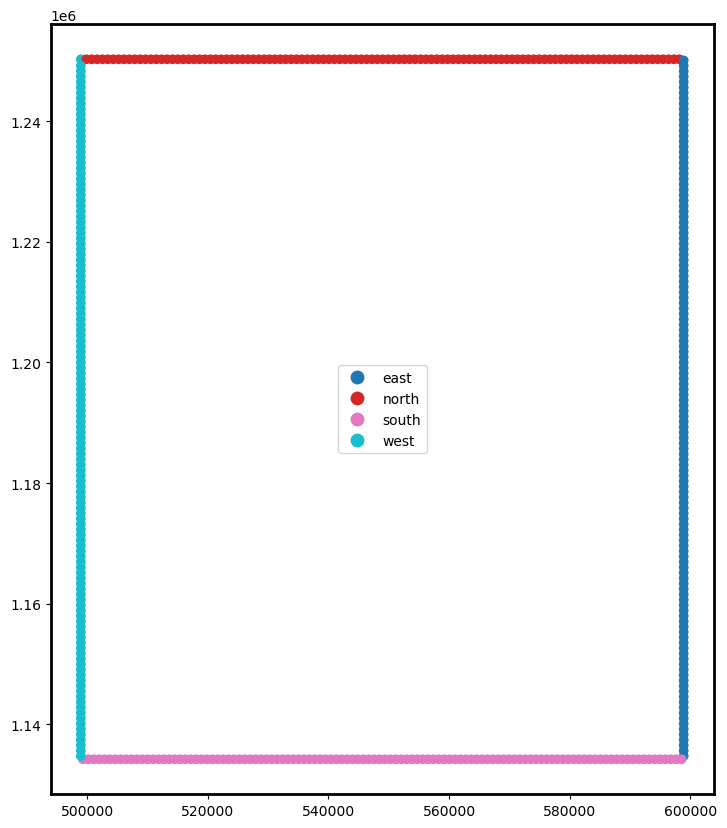

In [81]:
fig, ax = plt.subplots(figsize = (10,10))
#boundary_segments.plot(ax=ax,column='boundary',categorical=True,legend=True,color='k')
domain.plot(ax=ax,column='tag',categorical=True,legend=True)
plt.savefig('%s/boundarytags.png' %(mesh_path))


In [82]:
bounding_polygon = anuga.read_polygon('%s/%s_domain_points.csv' %(mesh_path,AOI))
A = anuga.polygon_area(bounding_polygon) / 1000000.0
print('################################# Bounding Polygon defined by :               %s_domain_points.csv' %(AOI))
print('################################# Area of bounding polygon:                   %.2f km^2' %(A))
print('################################# Base triangle area for unrefined areas:     %s km^2' %(base_length/1000000.00))



################################# Bounding Polygon defined by :               magdalena_domain_points.csv
################################# Area of bounding polygon:                   11597.78 km^2
################################# Base triangle area for unrefined areas:     0.000894 km^2


In [83]:
minlength = (min(mesh_triangles)*2)**0.5
maxlength = (max(mesh_triangles)*2)**0.5

interior_regions = []
missing = gpd.GeoDataFrame(columns =['geometry'], crs = EPSG)


In [84]:
if uniform == False:
    for mesh in range(len(mesh_shapefiles[:-1])):
        print(mesh)
        try:
            mesh_triangle = mesh_triangles[mesh]        #zone_scale = int(parameters['Zone%sScale' %(zone)].astype('float64'))     # Maximum triangle area in Zone A areas
        except:''
        else:
            print('################################# Max triangle area for %s:     %s km^2' %(mesh_names[mesh],mesh_triangle/1000000.00))
            mesh_length = (mesh_triangle*2)**0.5 # max area = (max length/2)^2
            zone_polygons = []

            ## ZONE
            zone_polygon = gpd.read_file(mesh_shapefiles[mesh])
            #zone_polygon.geometry = zone_polygon.buffer(2*int(maxlength))
            zone_polygon.geometry = zone_polygon.buffer(-int(minlength))
            zone_no_holes,holes = delete_holes(zone_polygon)
            zone_no_holes = zone_no_holes.explode(index_parts = True).reset_index(drop=True)

            columns = zone_no_holes.columns[:-1]
            zone_no_holes.drop(columns,inplace=True,axis=1)
            zone_filled = zone_no_holes.copy(deep=True)
            points = {'geometry':[Point(zone_no_holes.geometry[0].exterior.coords[0][0], zone_no_holes.geometry[0].exterior.coords[0][1])]}
            points = gpd.GeoDataFrame(points,crs=EPSG)
            rivercsv = []
            for g in range(zone_filled.shape[0]):
                try:
                    interior_regions.append([anuga.read_polygon("%s%s_%s%s_points_%s.csv" %(mesh_path,AOI,mesh_names[mesh],g,mesh_triangle)),mesh_triangle])

                except:
                    tempgdf = gpd.GeoDataFrame(geometry = zone_filled.loc[g])
                    #tempgdf.columns = ['geometry']
                    temp_filled,temp_points = getpolygonpoints(tempgdf,ulx,uly,lrx,lry,int(mesh_length))
                    if temp_points.shape[0]>3:
                        points_2,newxy = removenearbypoints(temp_points,domain, mesh_path,AOI,'%s%s' %(mesh_names[mesh],g),mesh_triangle,minlength)
                        np.savetxt("%s%s_%s%s_points_%s.csv" %(mesh_path,AOI,mesh_names[mesh],g,mesh_triangle),newxy,delimiter=',', fmt= '%1.9f')
                        print('%s%s_%s_points_%s.csv' %(mesh_path,AOI,'%s%s' %(mesh_names[mesh],g),mesh_triangle))
                       #rivercsv.append(deltapath+folders[6]+delta+'_river%s_points.csv' %(g))
                        try:
                            interior_regions.append([anuga.read_polygon(mesh_path+AOI+'_%s%s_points_%s.csv' %(mesh_names[mesh],g,mesh_triangle)),mesh_triangle])
                        except: print('BAD POLYGON --> BAD MESH. Excluding this polygon for the mesh generator')
                        else:
                            zone_filled.loc[g].geometry = temp_filled.geometry[0]
                            points = pd.concat((points,points_2),axis=0)
                            points = points.reset_index(drop=True)
                else:
                    points_2 = gpd.read_file("%s%s_%s%s_points_%s.csv" %(mesh_path,AOI,mesh_names[mesh],g,mesh_triangle))
                    #zone_filled.loc[g].geometry = temp_filled.geometry[0]
                    points = pd.concat((points,points_2),axis=0)
                    points = points.reset_index(drop=True)
                domain = pd.concat((domain,points),axis=0).reset_index(drop=True)
                missing = pd.concat((missing,zone_filled),axis=0)
            points.to_file("%s%s_points_%s_%s.shp" %(mesh_path,AOI,mesh_names[mesh],mesh_triangle))


    domain.to_file("%s%s_all_points.shp" %(mesh_path,AOI))

In [85]:
# fix,ax = plt.subplots(figsize=(10,10))

# colors = ['r','k','b','c','o','g']
# for mesh in range(len(mesh_shapefiles[:-1])):
#     tmp = gpd.read_file('%s%s_points_%s_%s.shp' %(mesh_path,AOI,mesh_names[mesh],mesh_triangles[mesh]))
#     tmp.plot(ax=ax,color=colors[mesh],label=mesh_names[mesh])
    
# ax.legend()

<font size='6' > Step #3:ff</font>


In [86]:
geo_reference = Geo_reference(zone=EPSG,
                                datum='wgs84',
                                projection='UTM',
                                false_easting=500000,
                                false_northing=0)

If you didn't run the Download notebook, the following cells will won't work. Go back to that notebook and download ancillary data.

In [87]:
if rectangular:
    anuga.create_mesh_from_regions(
        bounding_polygon,
        boundary_tags={'North': north[0],
                       'East': east[0],
                       'South': south[0],
                       'West': west[0]},
        maximum_triangle_area = base_triangle,
        filename =  str(mesh_path / (mesh_file + '.tsh')),
        interior_regions = interior_regions,
        use_cache = False,
        verbose = False,
        poly_geo_reference=geo_reference,
        mesh_geo_reference=geo_reference,
        )
else:
    anuga.create_mesh_from_regions(
        bounding_polygon,
        boundary_tags={'Tide': tide_tag,
                       'exterior': other_tag},
        maximum_triangle_area = base_triangle,
        filename =  str(mesh_path / (mesh_file + '.tsh')),
        interior_regions = interior_regions,
        use_cache = False,
        verbose = False,
        poly_geo_reference=geo_reference,
        mesh_geo_reference=geo_reference,
        )

    
    


In [88]:
mesh_domain = anuga.create_domain_from_file(str(mesh_path / (mesh_file+'.tsh')))

Figure files for each frame will be stored in /Users/alchrist/Documents/GitHub/BAM/examples/magdalena/Meshes/Meshes_base_400000m2/plot


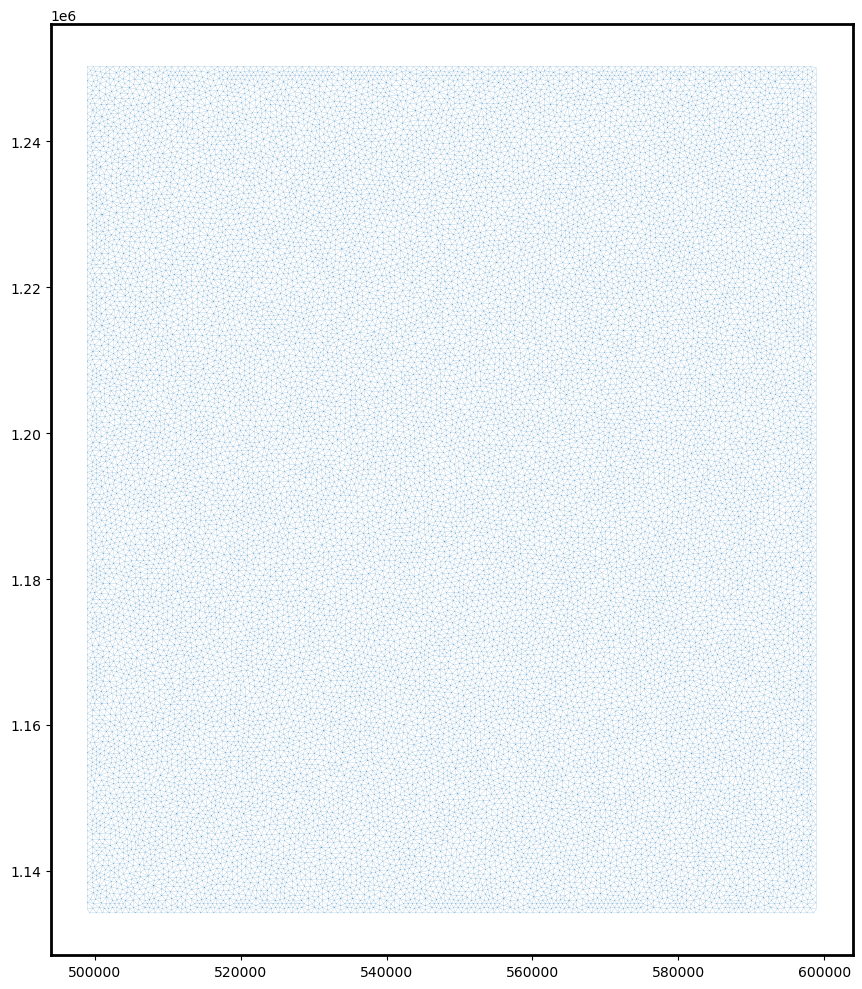

In [89]:


fig = plt.figure(figsize=(10,10))
dplotter = animate.Domain_plotter(mesh_domain,plot_dir = str(mesh_path /'plot'))
plt.triplot(dplotter.triang,linewidth=0.1)
plt.axis('scaled')
plt.tight_layout()
plt.savefig(mesh_path / ('plot/mesh%s.png' %(myid)))


In [90]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size=5 color='red'> Done building the mesh. Move on to the next notebook 5_RunANUGA.ipynb </font>


In [91]:
mesh_file

'Meshes_base_400000m2'